# Data Generation From Preprocessed CSV

In [58]:
import sys
sys.path.append("../")

import pandas as pd

from imblearn.over_sampling import SMOTE

from Dataset.data_generation_csv import *

## Generate Large Dataset

In [7]:
raw_train_df = pd.read_csv("Data/mitbih_train.csv", header=None)
raw_test_df = pd.read_csv("Data/mitbih_test.csv", header=None)

x_train = raw_train_df.iloc[:, :-1]
y_train = raw_train_df.iloc[:, -1]
x_test  = raw_test_df.iloc[:, :-1]
y_test  = raw_test_df.iloc[:, -1]

smote = SMOTE(sampling_strategy={1: 30000, 2: 20000, 3: 20000, 4: 10000}, random_state=0)
x_train, y_train = smote.fit_resample(x_train, y_train)

training_data = {
    "features": x_train,
    "labels"  : y_train,
}
test_data = {
    "features": x_test,
    "labels"  : y_test,
}

In [ ]:
visualize_raw_ecg(training_data)

In [ ]:
transform_data("Data/mitbih_mif_train.h5", training_data, batch_size=5000)
transform_data("Data/mitbih_mif_test.h5", test_data, batch_size=5000)

## Generate Small Training Set

In [18]:
raw_train_df = pd.read_csv("Data/mitbih_train.csv", header=None)

training_data = {
    "features": raw_train_df.iloc[60000:, :-1],
    "labels"  : raw_train_df.iloc[60000:, -1],
}

In [ ]:
transform_data("Data/mitbih_mif_train_small.h5", training_data, batch_size=5000)

## Generate Calibration Datasets For Quantization

In [ ]:
def process_data_frame(df, save_path):
    training_data = {
        "features": df.iloc[:, :-1],
        "labels":   df.iloc[:, -1]
    }
    transform_data(save_path, training_data, batch_size=1000)


def class_distribution(df):
    print(df.value_counts(normalize=True))

n_samples = 3200

# Original dataset
print("Original dataset class distribution")
raw_train_df = pd.read_csv("Data/mitbih_train.csv", header=None)
class_distribution(raw_train_df[187])
print()

# Random sample
random_sample = raw_train_df.sample(n=n_samples, random_state=1)
print("Processing random sample calibration set")
class_distribution(random_sample[187])
process_data_frame(random_sample, "Data/mitbih_calib_random.h5")
print()

# Balanced dataset
labels_df = []
for label in range(5):
    label_filtered_df = raw_train_df[raw_train_df[187] == label]
    labels_df.append(label_filtered_df.sample(n=(n_samples//5), random_state=1))

balanced_sample = pd.concat(labels_df, ignore_index=True)
print("Processing balanced sample calibration set")
class_distribution(balanced_sample[187])
process_data_frame(random_sample, "Data/mitbih_calib_balanced.h5")
print()


# Data Generation From Raw Database

## Full Sets

In [ ]:
import sys
sys.path.append("../")

from Dataset.data_generation import create_raw_dataset, create_image_dataset, create_train_test_from_dataset

window_size = 128
batch_size  = 2000

# Raw signal dataset
data_path  = "../Data/MIT-BIH-Raw/mit-bih-arrhythmia-database-1.0.0"
raw_path   = f"../Data/MIT-BIH-Raw/Datasets/Resolution-{window_size}/signal_full_unfiltered_i{window_size}.h5"

create_raw_dataset(data_path, raw_path, window_size, full=True)
create_train_test_from_dataset(
    dataset_path = raw_path,
    output_name  = f"signal_full_unfiltered_i{window_size}",
    ratio        = 0.8,
    data_key     = "segments",
    shuffle      = True,
    batch_size   = batch_size
)

# Image datasets
for split in ["train", "test"]:
    create_image_dataset(
        signal_dataset_path = f"../Data/MIT-BIH-Raw/Datasets/Resolution-{window_size}/signal_full_unfiltered_i{window_size}_{split}.h5", 
        output_path         = f"../Data/MIT-BIH-Raw/Datasets/Resolution-{window_size}/image_full_unfiltered_i{window_size}_{split}.h5",
        batch_size          = batch_size
    )

In [ ]:
import sys
sys.path.append("../")

from Dataset.data_generation import create_image_dataset_contiguous

window_sizes = [256, 224, 192, 160]
batch_size  = 1000

# Raw sets and train split are already created

# Image datasets
for window_size in window_sizes:
    create_image_dataset_contiguous(
        signal_dataset_path = f"../Data/MIT-BIH-Raw/Datasets/Resolution-{window_size}/signal_unfiltered_i{window_size}_train.h5", 
        output_path         = f"../Data/MIT-BIH-Raw/Datasets/Resolution-{window_size}/image_unfiltered_i{window_size}_train.h5",
        batch_size          = batch_size
    )

In [ ]:
import sys
sys.path.append("../")

from Dataset.data_generation import create_image_dataset_contiguous

create_image_dataset_contiguous(
    signal_dataset_path = f"../Data/MIT-BIH-Raw/Datasets/Resolution-256/signal_unfiltered_i256_test.h5", 
    output_path         = f"../Data/MIT-BIH-Raw/Datasets/Resolution-256/image_unfiltered_i256_test.h5",
    batch_size          = 1000
)

## Balanced vs Random

In [ ]:
import sys
sys.path.append("../")

from Dataset.data_generation import create_subset_from_dataset, create_image_dataset

for ratio in [0.7, 0.6, 0.5, 0.4, 0.3]:
    for method in ["balance", "random"]:
        create_subset_from_dataset(
            dataset_path = "../Data/MIT-BIH-Raw/Datasets/Resolution-128/signal_unfiltered_i128_train.h5",
            output_name  = f"signal_unfiltered_i128_train_r{ratio}_{method}",
            data_key     = "segments",
            method       = method,
            ratio        = ratio,
            shuffle      = False, # Base dataset is already shuffled
            batch_size   = 5000
        )
        create_image_dataset(
            signal_dataset_path = f"../Data/MIT-BIH-Raw/Datasets/Resolution-128/signal_unfiltered_i128_train_r{ratio}_{method}.h5",
            output_path         = f"../Data/MIT-BIH-Raw/Datasets/Resolution-128/image_unfiltered_i128_train_r{ratio}_{method}.h5",
            batch_size          = 5000
        )

In [ ]:
import sys
sys.path.append("../")

import h5py

from Dataset.data_generation import get_class_distribution

norm = False
with h5py.File("../Data/MIT-BIH-Raw/Datasets/Resolution-128/image_unfiltered_i128_train.h5", "r") as hdf:
    labels = hdf["labels"][:]
    print(f"Base:         {len(labels)}, {get_class_distribution(labels, normalize=norm)}")

for ratio in [0.7, 0.6, 0.5, 0.4, 0.3]:
    with h5py.File(f"../Data/MIT-BIH-Raw/Datasets/Resolution-128/image_unfiltered_i128_train_r{ratio}_balance.h5", "r") as hdf:
        labels = hdf["labels"][:]
        print(f"Balanced {ratio}: {len(labels)}, {get_class_distribution(labels, normalize=norm)}")

    with h5py.File(f"../Data/MIT-BIH-Raw/Datasets/Resolution-128/image_unfiltered_i128_train_r{ratio}_random.h5", "r") as hdf:
        labels = hdf["labels"][:]
        print(f"Random   {ratio}: {len(labels)}, {get_class_distribution(labels, normalize=norm)}")

## Multi Resolution

In [ ]:
import sys
sys.path.append("../")

from Dataset.data_generation import create_subset_from_dataset, create_image_dataset, create_raw_dataset, create_train_test_from_dataset

data_path   = "../Data/MIT-BIH-Raw/mit-bih-arrhythmia-database-1.0.0"
batch_size  = 1000
set_configs = [(248, 0.3), (232, 0.3), (216, 0.4), (200, 0.4), (184, 0.4), (168, 0.5), (152, 0.6), (136, 0.6)]

for window_size, ratio in set_configs:
    raw_path = f"../Data/MIT-BIH-Raw/Datasets/Resolution-{window_size}/signal_unfiltered_i{window_size}.h5"

    # Raw
    create_raw_dataset(data_path, raw_path, window_size)

    # Train-test
    create_train_test_from_dataset(
        dataset_path = raw_path,
        output_name  = f"signal_unfiltered_i{window_size}",
        ratio        = 0.8,
        data_key     = "segments",
        shuffle      = True,
        batch_size   = batch_size
    )
    for method in ["balance"]:
        # Subset
        create_subset_from_dataset(
            dataset_path = f"../Data/MIT-BIH-Raw/Datasets/Resolution-{window_size}/signal_unfiltered_i{window_size}_train.h5",
            output_path  = f"../Data/MIT-BIH-Raw/Datasets/Resolution-{window_size}/signal_unfiltered_i{window_size}_train_r{ratio}_{method}.h5",
            data_key     = "segments",
            method       = method,
            ratio        = ratio,
            shuffle      = False, # Base dataset is already shuffled
            batch_size   = batch_size
        )

        # Image train
        create_image_dataset(
            signal_dataset_path = f"../Data/MIT-BIH-Raw/Datasets/Resolution-{window_size}/signal_unfiltered_i{window_size}_train_r{ratio}_{method}.h5",
            output_path         = f"../Data/MIT-BIH-Raw/Datasets/Resolution-{window_size}/image_unfiltered_i{window_size}_train_r{ratio}_{method}.h5",
            batch_size          = batch_size
        )

In [ ]:
import sys
sys.path.append("../")

from Dataset.data_generation import create_raw_dataset, create_image_dataset, create_train_test_from_dataset

window_size = 64
batch_size  = 1000

# Raw signal dataset
data_path  = "../Data/MIT-BIH-Raw/mit-bih-arrhythmia-database-1.0.0"
raw_path   = f"../Data/MIT-BIH-Raw/Datasets/Resolution-{window_size}/signal_unfiltered_i{window_size}.h5"

create_raw_dataset(data_path, raw_path, window_size)
create_train_test_from_dataset(
    dataset_path = raw_path,
    output_name  = f"signal_unfiltered_i{window_size}",
    ratio        = 0.8,
    data_key     = "segments",
    shuffle      = True,
    batch_size   = batch_size
)

# Image datasets
for split in ["train", "test"]:
    create_image_dataset(
        signal_dataset_path = f"../Data/MIT-BIH-Raw/Datasets/Resolution-{window_size}/signal_unfiltered_i{window_size}_{split}.h5", 
        output_path         = f"../Data/MIT-BIH-Raw/Datasets/Resolution-{window_size}/image_unfiltered_i{window_size}_{split}.h5",
        batch_size          = batch_size
    )

## Downscale And Crop

In [ ]:
import sys
sys.path.append("../")

from Dataset.data_generation import create_raw_dataset, create_image_dataset, create_train_test_from_dataset, create_preprocessed_dataset

data_path  = "../Data/MIT-BIH-Raw/mit-bih-arrhythmia-database-1.0.0"
batch_size = 1000

original_size = 256
new_size      = 128

# Create the base raw datasets first
create_raw_dataset(
    data_path   = data_path, 
    output_path = f"../Data/MIT-BIH-Raw/Datasets/Resolution-{original_size}/signal_unfiltered_i{original_size}.h5", 
    window_size = original_size
)
create_train_test_from_dataset(
    dataset_path = f"../Data/MIT-BIH-Raw/Datasets/Resolution-{original_size}/signal_unfiltered_i{original_size}.h5",
    output_name  = f"signal_unfiltered_i{original_size}",
    ratio        = 0.8,
    data_key     = "segments",
    shuffle      = True,
    batch_size   = batch_size
)
for split in ["train", "test"]:
    create_image_dataset(
        signal_dataset_path = f"../Data/MIT-BIH-Raw/Datasets/Resolution-{original_size}/signal_unfiltered_i{original_size}_{split}.h5", 
        output_path         = f"../Data/MIT-BIH-Raw/Datasets/Resolution-{original_size}/image_unfiltered_i{original_size}_{split}.h5",
        batch_size          = batch_size
    )

for method in ["resize", "crop"]:
    for split in ["train", "test"]:
        create_preprocessed_dataset(
            dataset_path = f"../Data/MIT-BIH-Raw/Datasets/Resolution-{original_size}/image_unfiltered_i{original_size}_{split}.h5",
            output_path  = f"../Data/MIT-BIH-Raw/Datasets/Resolution-{new_size}/image_{method}_i{new_size}_{split}.h5",
            data_key     = "images",
            method       = method,
            new_size     = new_size,
            batch_size   = batch_size
        )

In [ ]:
import sys
sys.path.append("../")

from Dataset.data_generation import create_subset_from_dataset, create_image_dataset

data_path  = "../Data/MIT-BIH-Raw/mit-bih-arrhythmia-database-1.0.0"
batch_size = 1000

original_size = 256
config = [(256, 0.3)]
# config = [(256, 0.3), (224, 0.3), (192, 0.4), (160, 0.5)]

for resolution, ratio in config:
    create_subset_from_dataset(
        dataset_path = f"../Data/MIT-BIH-Raw/Datasets/Resolution-{original_size}/signal_unfiltered_i{original_size}_train.h5",
        output_path  = f"../Data/MIT-BIH-Raw/Datasets/Resolution-{original_size}/signal_unfiltered_i{original_size}_train_r{ratio}.h5",
        data_key     = "segments",
        method       = "balance",
        ratio        = ratio,
        shuffle      = True,
        batch_size   = batch_size
    )

    if resolution == original_size:
        create_image_dataset(
            signal_dataset_path = f"../Data/MIT-BIH-Raw/Datasets/Resolution-{original_size}/signal_unfiltered_i{original_size}_train_r{ratio}.h5",
            output_path         = f"../Data/MIT-BIH-Raw/Datasets/Resolution-{resolution}/image_resize_i{resolution}_train_r{ratio}.h5",
            batch_size          = batch_size,
        )
    else:
        create_image_dataset(
            signal_dataset_path = f"../Data/MIT-BIH-Raw/Datasets/Resolution-{original_size}/signal_unfiltered_i{original_size}_train_r{ratio}.h5",
            output_path         = f"../Data/MIT-BIH-Raw/Datasets/Resolution-{resolution}/image_resize_i{resolution}_train_r{ratio}.h5",
            batch_size          = batch_size,
            preprocess          = "resize",
            new_size            = resolution
        )

## Visualization

In [ ]:
import sys
sys.path.append("../")

import h5py
import numpy as np
import matplotlib.pyplot as plt

def visualize_image(images: dict[str, np.ndarray]) -> None:
    _, axs = plt.subplots(3, 3, figsize=(10, 10))
    for i, (name, img_chw) in enumerate(images.items()):
        for j, img_hw in enumerate(img_chw):
            axs[i, j].imshow(img_hw)
            axs[i, j].axis(False)
        axs[i, 0].set_ylabel(name)

    plt.show()

image_idx = 100
images = dict()
with h5py.File("../Data/MIT-BIH-Raw/Datasets/Resolution-128/image_unfiltered_i128_train.h5", "r") as hdf:
    images["Normal"] = hdf["images"][image_idx]
    
with h5py.File("../Data/MIT-BIH-Raw/Datasets/Resolution-128/image_resize_i128_train.h5", "r") as hdf:
    images["Downscale"] = hdf["images"][image_idx]

with h5py.File("../Data/MIT-BIH-Raw/Datasets/Resolution-128/image_crop_i128_train.h5", "r") as hdf:
    images["Center Crop"] = hdf["images"][image_idx]

visualize_image(images)

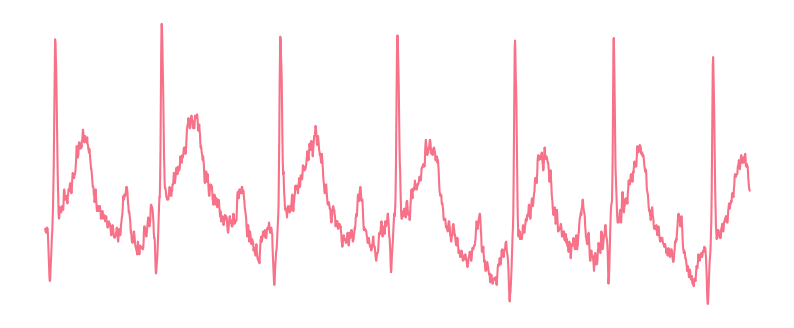

In [7]:
import sys
sys.path.append("../")

import h5py
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

def plot_raw_signal(signal: np.ndarray) -> None:
    sns.set_style("whitegrid")
    sns.set_palette("husl")

    _, ax = plt.subplots(figsize=(10, 4))
    ax.plot(signal)
    ax.axis(False)

    plt.show()

# for i in [224, 192, 160, 128]:
#     with h5py.File(f"../Data/MIT-BIH-Raw/Datasets/Resolution-{i}/signal_resample_i{i}_train.h5", "r") as hdf:
#         signal = hdf["segments"][100]
#         plot_raw_signal(signal)

with h5py.File(f"../Data/MIT-BIH-Raw/Datasets/Resolution-2000/signal_full_unfiltered_i2000_train.h5", "r") as hdf:
    signal = hdf["segments"][5]
    plot_raw_signal(signal)

## Full Dataset Split

In [ ]:
import sys
sys.path.append("../")

from Dataset.data_generation import create_full_split_sets, create_image_dataset_contiguous

batch_size  = 1000
set_configs = [(256, 4), (224, 3), (192, 2), (160, 2)]

for res, num_subsets in set_configs:
    create_full_split_sets(
        dataset_path = f"../Data/MIT-BIH-Raw/Datasets/Resolution-{res}/signal_unfiltered_i{res}_train.h5",
        output_dir   = f"../Data/MIT-BIH-Raw/Datasets/Resolution-{res}/unfiltered_i{res}_train_full_split_{num_subsets}",
        data_key     = "segments",
        num_sets     = num_subsets,
        shuffle      = False, # Base dataset is already shuffled
        batch_size   = batch_size
    )
    for i in range(num_subsets):
        create_image_dataset_contiguous(
            signal_dataset_path = f"../Data/MIT-BIH-Raw/Datasets/Resolution-{res}/unfiltered_i{res}_train_full_split_{num_subsets}/set_{i}.h5",
            output_path         = f"../Data/MIT-BIH-Raw/Datasets/Resolution-{res}/unfiltered_i{res}_train_full_split_{num_subsets}/image_set_{i}.h5",
            batch_size          = batch_size
        )

## Resample

In [ ]:
import sys
sys.path.append("../")

from Dataset.data_generation import create_preprocessed_dataset, create_image_dataset_contiguous

batch_size  = 1000
set_configs = [224, 192, 160, 128]

for res in set_configs:
    create_preprocessed_dataset(
        dataset_path = f"../Data/MIT-BIH-Raw/Datasets/Resolution-256/signal_unfiltered_i256_train.h5",
        output_path  = f"../Data/MIT-BIH-Raw/Datasets/Resolution-{res}/signal_resample_i{res}_train.h5",
        data_key     = "segments",
        data_type    = "signal",
        method       = "resample",
        new_size     = res,
        batch_size   = batch_size,
    )
    create_image_dataset_contiguous(
        signal_dataset_path = f"../Data/MIT-BIH-Raw/Datasets/Resolution-{res}/signal_resample_i{res}_train.h5",
        output_path         = f"../Data/MIT-BIH-Raw/Datasets/Resolution-{res}/image_resample_i{res}_train.h5",
        batch_size          = batch_size,
    )

    if res == 128: # Test set
        create_preprocessed_dataset(
            dataset_path = f"../Data/MIT-BIH-Raw/Datasets/Resolution-256/signal_unfiltered_i256_test.h5",
            output_path  = f"../Data/MIT-BIH-Raw/Datasets/Resolution-{res}/signal_resample_i{res}_test.h5",
            data_key     = "segments",
            data_type    = "signal",
            method       = "resample",
            new_size     = res,
            batch_size   = batch_size,
        )
        create_image_dataset_contiguous(
            signal_dataset_path = f"../Data/MIT-BIH-Raw/Datasets/Resolution-{res}/signal_resample_i{res}_test.h5",
            output_path         = f"../Data/MIT-BIH-Raw/Datasets/Resolution-{res}/image_resample_i{res}_test.h5",
            batch_size          = batch_size,
        )   

In [ ]:
import sys
sys.path.append("../")

from Dataset.data_generation import create_preprocessed_dataset, create_image_dataset_contiguous, create_subset_from_dataset

batch_size  = 1000
set_configs = [(224, 0.3), (192, 0.4), (160, 0.5)]

for res, size in set_configs:
    create_subset_from_dataset(
        dataset_path = "../Data/MIT-BIH-Raw/Datasets/Resolution-256/signal_unfiltered_i256_train.h5",
        output_path  = f"../Data/MIT-BIH-Raw/Datasets/Resolution-256/signal_unfiltered_i256_train_r{size}.h5",
        data_key     = "segments",
        method       = "balance",
        ratio        = size,
        shuffle      = True,
        batch_size   = batch_size,
    )
    create_preprocessed_dataset(
        dataset_path = f"../Data/MIT-BIH-Raw/Datasets/Resolution-256/signal_unfiltered_i256_train_r{size}.h5",
        output_path  = f"../Data/MIT-BIH-Raw/Datasets/Resolution-{res}/signal_resample_i{res}_train_r{size}.h5",
        data_key     = "segments",
        data_type    = "signal",
        method       = "resample",
        new_size     = res,
        batch_size   = batch_size,
    )
    create_image_dataset_contiguous(
        signal_dataset_path = f"../Data/MIT-BIH-Raw/Datasets/Resolution-{res}/signal_resample_i{res}_train_r{size}.h5",
        output_path         = f"../Data/MIT-BIH-Raw/Datasets/Resolution-{res}/image_resample_i{res}_train_r{size}.h5",
        batch_size          = batch_size,
    )

In [1]:
import sys
sys.path.append("../")

from Dataset.data_generation import create_raw_dataset, create_preprocessed_dataset, create_train_test_from_dataset

window_size = 2000
batch_size  = 1000

# Raw signal dataset
data_path  = "../Data/MIT-BIH-Raw/mit-bih-arrhythmia-database-1.0.0"
raw_path   = f"../Data/MIT-BIH-Raw/Datasets/Resolution-{window_size}/signal_full_unfiltered_i{window_size}.h5"

create_raw_dataset(data_path, raw_path, window_size, full=True)
create_train_test_from_dataset(
    dataset_path = raw_path,
    output_name  = f"signal_full_unfiltered_i{window_size}",
    ratio        = 0.8,
    data_key     = "segments",
    shuffle      = True,
    batch_size   = batch_size
)

[2024-08-05 12:43:00,178] [DTGEN] [INFO] Processing all records
[2024-08-05 12:43:00,178] [DTGEN] [INFO] 	Processing Record 100
[2024-08-05 12:43:00,244] [DTGEN] [INFO] 		Heartbeats: 2265
[2024-08-05 12:43:00,245] [DTGEN] [INFO] 		Classes: {'normal': 2231, 'sveb': 33, 'veb': 1, 'fusion': 0, 'unknown': 0}
[2024-08-05 12:43:00,303] [DTGEN] [INFO] 	Record 100 added to dataset ../Data/MIT-BIH-Raw/Datasets/Resolution-2000/signal_full_unfiltered_i2000.h5 in 0.1246s
[2024-08-05 12:43:00,304] [DTGEN] [INFO] 	Processing Record 101
[2024-08-05 12:43:00,358] [DTGEN] [INFO] 		Heartbeats: 1859
[2024-08-05 12:43:00,359] [DTGEN] [INFO] 		Classes: {'normal': 1854, 'sveb': 3, 'veb': 0, 'fusion': 0, 'unknown': 2}
[2024-08-05 12:43:00,406] [DTGEN] [INFO] 	Record 101 added to dataset ../Data/MIT-BIH-Raw/Datasets/Resolution-2000/signal_full_unfiltered_i2000.h5 in 0.1023s
[2024-08-05 12:43:00,406] [DTGEN] [INFO] 	Processing Record 102
[2024-08-05 12:43:00,466] [DTGEN] [INFO] 		Heartbeats: 2180
[2024-08-05 1